In [1]:
import pandas as pd
import numpy as np
import missingno as msn
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report,roc_auc_score
# from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier
# from imblearn.over_sampling import SMOTE
# from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
#from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
#from catboost import CatBoostClassifier
#import category_encoders

In [192]:
train=pd.read_csv('train.csv')

item_data=pd.read_csv('item_data.csv')

customer_transaction_data=pd.read_csv('customer_transaction_data.csv')

customer_demographics=pd.read_csv('customer_demographics.csv')

coupon_item_mapping=pd.read_csv('coupon_item_mapping.csv')

campaign_data=pd.read_csv('campaign_data.csv')


test=pd.read_csv('test_QyjYwdj.csv')


In [193]:
coupon_item_mapping.head(3)

,coupon_id,item_id
0,105,37
1,107,75
2,494,76


In [194]:
customer_demographics.head(3)

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3


In [195]:
customer_transaction_data.head(3)

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0


In [196]:
campaign_data.head(3)

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13


In [197]:
test.head(3)

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510


In [198]:
train.head(3)

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0


In [199]:
item_data.head(3)

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery


In [200]:
len(coupon_item_mapping['item_id'].unique())

36289

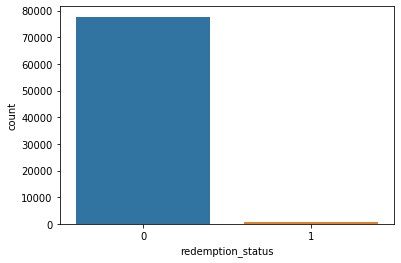

In [201]:
sns.countplot(train['redemption_status'])

In [202]:
train[train['redemption_status']==1].shape,train[train['redemption_status']==0].shape

((729, 5), (77640, 5))

In [203]:
729/(77640+729)

0.00930214753282548

In [204]:
campaign_data.start_date = pd.to_datetime(campaign_data.start_date, format = "%d/%m/%y")
campaign_data.end_date = pd.to_datetime(campaign_data.end_date, format = "%d/%m/%y")

campaign_data['campaign_duration'] = (campaign_data['end_date'] - campaign_data['start_date']).dt.days
campaign_data['campaign_type'] = campaign_data['campaign_type'].map(lambda x : 1 if x == 'Y' else 0)
customer_demographics['marital_status'] = customer_demographics['marital_status'].astype(str).map(lambda x : 1 if x == 'Married' else 0 if x == 'Single' else -1)
customer_demographics['age_range'] = customer_demographics['age_range'].map(lambda x : int(x.replace("+", "").split("-")[0]))
customer_demographics['no_of_children'] = customer_demographics['no_of_children'].fillna(0).astype(str).map(lambda x : int(x.replace("+", "")))
customer_demographics['family_size'] = customer_demographics['family_size'].fillna(0).astype(str).map(lambda x : int(x.replace("+", "")))


# Merging Tables

In [205]:
z=pd.merge(coupon_item_mapping,customer_transaction_data,how='left',on='item_id')


In [206]:
z.head()

,coupon_id,item_id,date,customer_id,quantity,selling_price,other_discount,coupon_discount
0,105,37,2012-03-11,1044.0,1.0,47.73,-11.04,0.0
1,105,37,2012-05-15,1044.0,3.0,142.48,-33.84,0.0
2,105,37,2012-08-23,1044.0,3.0,142.48,-27.43,0.0
3,105,37,2012-10-09,1044.0,2.0,95.11,-18.17,0.0
4,105,37,2012-10-26,1044.0,3.0,169.91,0.00,0.0


In [207]:
y=pd.merge(z,item_data,how='left',on='item_id')

In [208]:
y.shape

(2101369, 11)

In [209]:
y.head()

,coupon_id,item_id,date,customer_id,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category
0,105,37,2012-03-11,1044.0,1.0,47.73,-11.04,0.0,56,Local,Grocery
1,105,37,2012-05-15,1044.0,3.0,142.48,-33.84,0.0,56,Local,Grocery
2,105,37,2012-08-23,1044.0,3.0,142.48,-27.43,0.0,56,Local,Grocery
3,105,37,2012-10-09,1044.0,2.0,95.11,-18.17,0.0,56,Local,Grocery
4,105,37,2012-10-26,1044.0,3.0,169.91,0.00,0.0,56,Local,Grocery


In [210]:
len(coupon_item_mapping['item_id'].unique()),len(y['item_id'].unique())

(36289, 36289)

In [211]:
tr=pd.merge(train,y,how='left',on=['customer_id','coupon_id'])
ts=pd.merge(test,y,how='left',on=['customer_id','coupon_id'])

In [212]:
tr.shape

(205549, 14)

In [213]:
tr.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,item_id,date,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category
0,1,13,27,1053,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,13,116,48,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,9,635,205,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,8,1017,1489,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


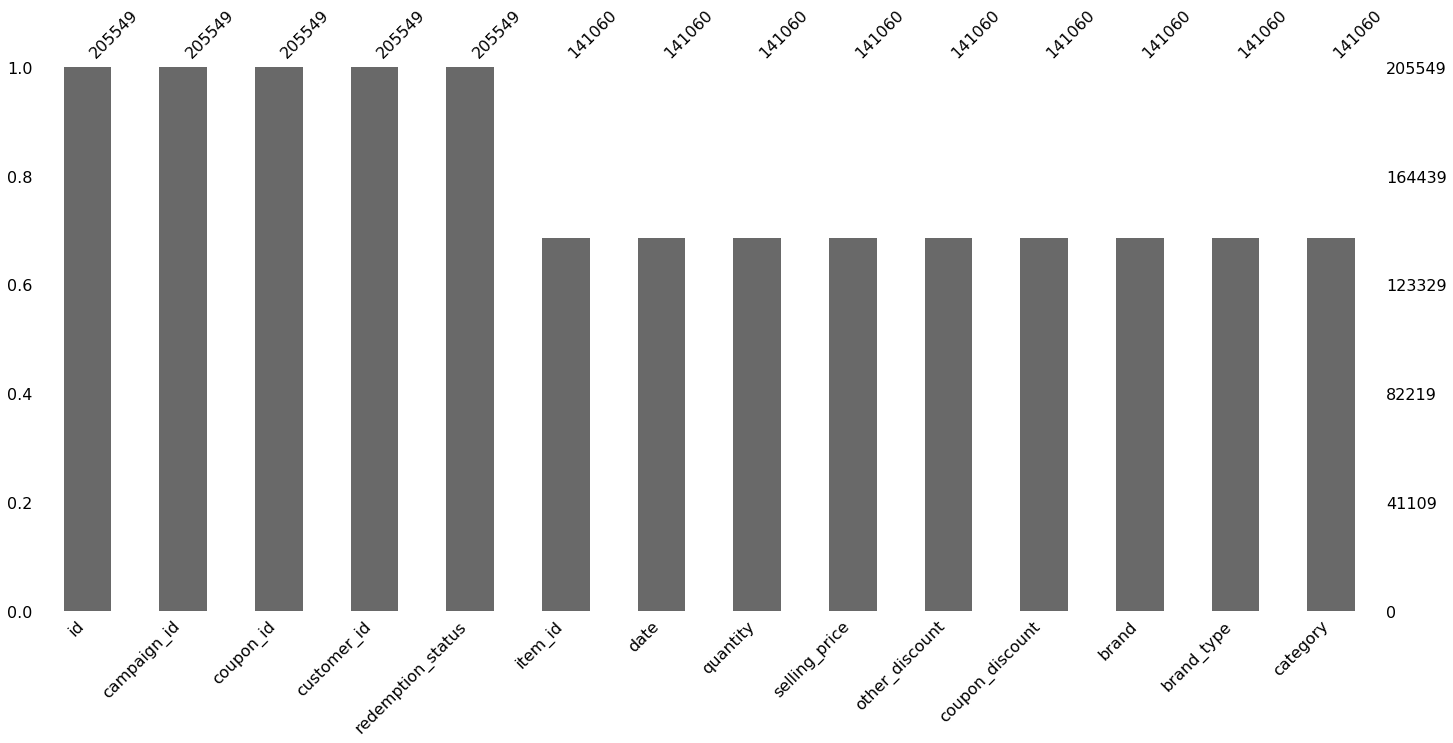

In [214]:
msn.bar(tr)

In [215]:
len(tr['coupon_id'].unique()),len(tr['campaign_id'].unique()),len(tr['customer_id'].unique())

(866, 18, 1428)

In [216]:
tr.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,item_id,date,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category
0,1,13,27,1053,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,13,116,48,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,9,635,205,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,8,1017,1489,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
len(tr['campaign_id'].unique())

18

# when Item is not present ---> no redemption

In [277]:
tr[(tr.item_id.isnull())&(tr.redemption_status==1)].tail()

,id,campaign_id,coupon_id,customer_id,redemption_status,item_id,date,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category


In [219]:
len(tr['id'].unique())

78369

# --data where item_id is present


In [220]:
new_tr=tr[(tr.item_id.notnull())]
new_ts=ts[(ts.item_id.notnull())]

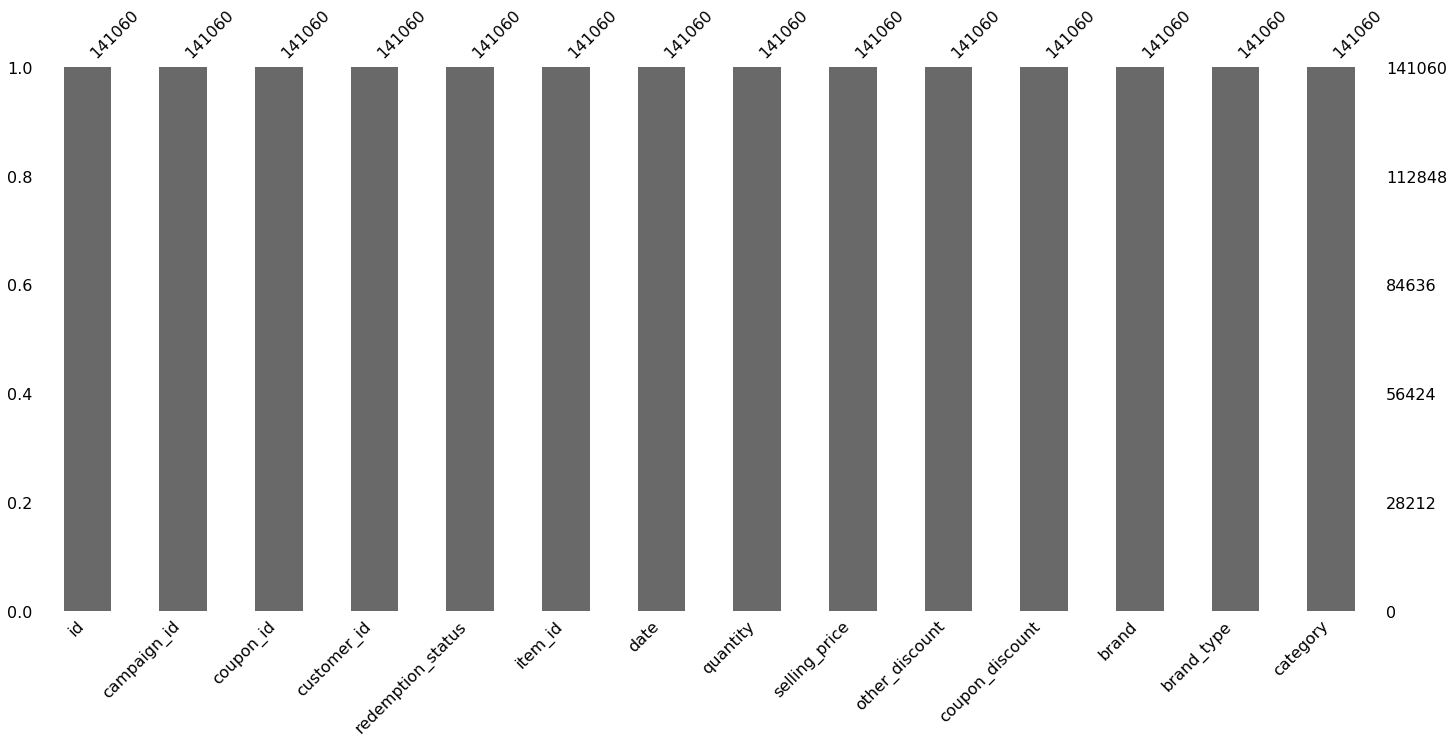

In [221]:
msn.bar(new_tr)

In [222]:
a=pd.merge(new_tr,campaign_data,how='left',on='campaign_id')
a1=pd.merge(new_ts,campaign_data,how='left',on='campaign_id')
a1.head()

,id,campaign_id,coupon_id,customer_id,item_id,date,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category,campaign_type,start_date,end_date,campaign_duration
0,3,22,869,967,4803.0,2012-08-31,1.0,177.74,-42.74,0.00,1075.0,Established,Grocery,0,2013-09-16,2013-10-18,32
1,3,22,869,967,4803.0,2012-10-26,1.0,184.87,-35.62,0.00,1075.0,Established,Grocery,0,2013-09-16,2013-10-18,32
2,3,22,869,967,14473.0,2012-11-30,1.0,159.93,-35.62,0.00,1075.0,Established,Grocery,0,2013-09-16,2013-10-18,32
3,3,22,869,967,14473.0,2013-04-19,1.0,159.93,-35.62,0.00,1075.0,Established,Grocery,0,2013-09-16,2013-10-18,32
4,3,22,869,967,16344.0,2012-08-24,1.0,106.50,-89.05,-35.62,1075.0,Established,Grocery,0,2013-09-16,2013-10-18,32


In [223]:
b=pd.merge(a,customer_demographics,how='left',on='customer_id')
b1=pd.merge(a1,customer_demographics,how='left',on='customer_id')
b.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,item_id,date,quantity,selling_price,other_discount,...,campaign_type,start_date,end_date,campaign_duration,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,15,29,538,368,0,9962.0,2013-05-30,1.0,45.95,0.00,...,1,2012-10-08,2012-11-30,53,36.0,-1.0,0.0,1.0,0.0,5.0
1,15,29,538,368,0,29027.0,2013-05-30,1.0,45.95,0.00,...,1,2012-10-08,2012-11-30,53,36.0,-1.0,0.0,1.0,0.0,5.0
2,21,13,1028,89,0,52056.0,2012-06-24,1.0,71.24,-28.14,...,0,2013-05-19,2013-07-05,47,46.0,-1.0,0.0,1.0,0.0,3.0
3,22,9,705,712,0,4904.0,2013-06-11,1.0,113.63,-39.18,...,1,2013-03-11,2013-04-12,32,46.0,1.0,0.0,3.0,1.0,5.0
4,22,9,705,712,0,4904.0,2013-06-20,1.0,113.63,-39.18,...,1,2013-03-11,2013-04-12,32,46.0,1.0,0.0,3.0,1.0,5.0


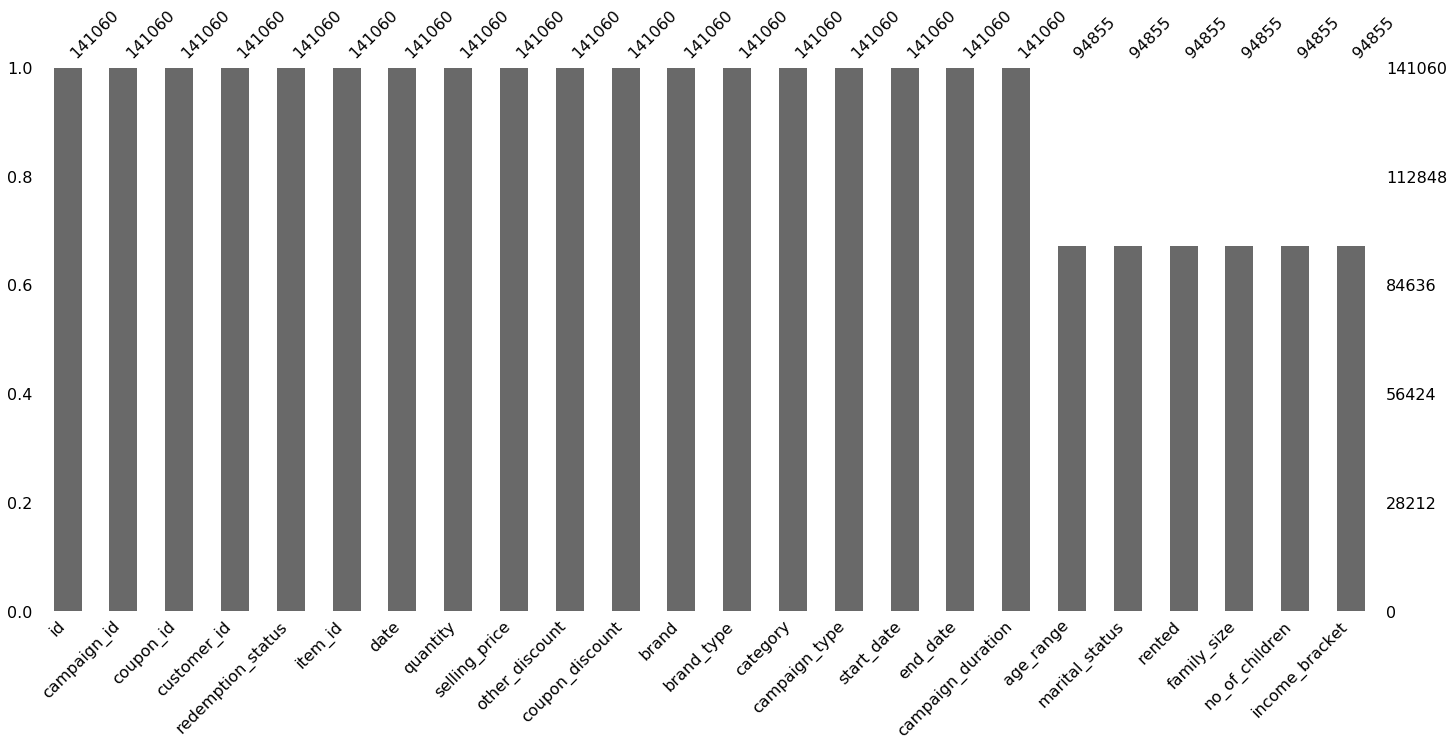

In [224]:
msn.bar(b)

In [225]:
ar=pd.to_datetime(b.end_date)-pd.to_datetime(b.start_date)
b['campaign_length']=ar/np.timedelta64(1, 'D')


br=pd.to_datetime(b1.end_date)-pd.to_datetime(b1.start_date)
b1['campaign_length']=br/np.timedelta64(1, 'D')


In [226]:
del b['start_date']
del b['end_date']
del b['date']

del b1['start_date']
del b1['end_date']
del b1['date']

In [227]:
y=b['redemption_status']
del b['redemption_status']
del b['customer_id']
del b1['customer_id']

In [228]:
b.head()

,id,campaign_id,coupon_id,item_id,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category,campaign_type,campaign_duration,age_range,marital_status,rented,family_size,no_of_children,income_bracket,campaign_length
0,15,29,538,9962.0,1.0,45.95,0.00,0.0,278.0,Established,Grocery,1,53,36.0,-1.0,0.0,1.0,0.0,5.0,53.0
1,15,29,538,29027.0,1.0,45.95,0.00,0.0,278.0,Established,Grocery,1,53,36.0,-1.0,0.0,1.0,0.0,5.0,53.0
2,21,13,1028,52056.0,1.0,71.24,-28.14,0.0,1639.0,Established,Grocery,0,47,46.0,-1.0,0.0,1.0,0.0,3.0,47.0
3,22,9,705,4904.0,1.0,113.63,-39.18,0.0,714.0,Established,Grocery,1,32,46.0,1.0,0.0,3.0,1.0,5.0,32.0
4,22,9,705,4904.0,1.0,113.63,-39.18,0.0,714.0,Established,Grocery,1,32,46.0,1.0,0.0,3.0,1.0,5.0,32.0


In [229]:
b['family_size'].values[0]

1.0

In [230]:
b['age_range'].unique()

array([36., 46., 26., 56., nan, 70., 18.])

In [231]:
b['total_discount']=b['other_discount'].abs() + b['coupon_discount'].abs()

b1['total_discount']=b1['other_discount'].abs() + b1['coupon_discount'].abs()

In [232]:
b['total_discount_with_quantity']=b['total_discount']*b['quantity']

b1['total_discount_with_quantity']=b1['total_discount']*b1['quantity']

In [233]:
b['selling_price_per_item'] = b.selling_price/b.quantity
b['other_discount_per_item'] = b.other_discount/b.quantity
b['coupon_discount_per_item'] = b.coupon_discount/b.quantity
b['total_discount'] = -1 * (b['other_discount'] + b['coupon_discount'])
b['price_before_discount'] = b['selling_price'] + b['total_discount']
b['total_discount_perc'] = b['total_discount'] / b['price_before_discount']
b['item_best_deal'] = b[['item_id', 'selling_price_per_item']].groupby('item_id').cummin()
b['item_curr_deal_vs_best_deal'] = (b['selling_price_per_item'] - b['item_best_deal'])*b.quantity

In [234]:
b1['selling_price_per_item'] = b1.selling_price/b1.quantity
b1['other_discount_per_item'] = b1.other_discount/b1.quantity
b1['coupon_discount_per_item'] = b1.coupon_discount/b1.quantity
b1['total_discount'] = -1 * (b1['other_discount'] + b1['coupon_discount'])
b1['price_b1efore_discount'] = b1['selling_price'] + b1['total_discount']
b1['total_discount_perc'] = b1['total_discount'] / b1['price_b1efore_discount']
b1['item_b1est_deal'] = b1[['item_id', 'selling_price_per_item']].groupby('item_id').cummin()
b1['item_curr_deal_vs_b1est_deal'] = (b1['selling_price_per_item'] - b1['item_b1est_deal'])*b1.quantity

In [235]:
b.head()

,id,campaign_id,coupon_id,item_id,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,...,campaign_length,total_discount,total_discount_with_quantity,selling_price_per_item,other_discount_per_item,coupon_discount_per_item,price_before_discount,total_discount_perc,item_best_deal,item_curr_deal_vs_best_deal
0,15,29,538,9962.0,1.0,45.95,0.00,0.0,278.0,Established,...,53.0,-0.00,0.00,45.95,0.00,0.0,45.95,-0.000000,45.95,0.0
1,15,29,538,29027.0,1.0,45.95,0.00,0.0,278.0,Established,...,53.0,-0.00,0.00,45.95,0.00,0.0,45.95,-0.000000,45.95,0.0
2,21,13,1028,52056.0,1.0,71.24,-28.14,0.0,1639.0,Established,...,47.0,28.14,28.14,71.24,-28.14,0.0,99.38,0.283156,71.24,0.0
3,22,9,705,4904.0,1.0,113.63,-39.18,0.0,714.0,Established,...,32.0,39.18,39.18,113.63,-39.18,0.0,152.81,0.256397,113.63,0.0
4,22,9,705,4904.0,1.0,113.63,-39.18,0.0,714.0,Established,...,32.0,39.18,39.18,113.63,-39.18,0.0,152.81,0.256397,113.63,0.0


In [236]:
b1.head()

,id,campaign_id,coupon_id,item_id,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,...,campaign_length,total_discount,total_discount_with_quantity,selling_price_per_item,other_discount_per_item,coupon_discount_per_item,price_b1efore_discount,total_discount_perc,item_b1est_deal,item_curr_deal_vs_b1est_deal
0,3,22,869,4803.0,1.0,177.74,-42.74,0.00,1075.0,Established,...,32.0,42.74,42.74,177.74,-42.74,0.00,220.48,0.193850,177.74,0.00
1,3,22,869,4803.0,1.0,184.87,-35.62,0.00,1075.0,Established,...,32.0,35.62,35.62,184.87,-35.62,0.00,220.49,0.161549,177.74,7.13
2,3,22,869,14473.0,1.0,159.93,-35.62,0.00,1075.0,Established,...,32.0,35.62,35.62,159.93,-35.62,0.00,195.55,0.182153,159.93,0.00
3,3,22,869,14473.0,1.0,159.93,-35.62,0.00,1075.0,Established,...,32.0,35.62,35.62,159.93,-35.62,0.00,195.55,0.182153,159.93,0.00
4,3,22,869,16344.0,1.0,106.50,-89.05,-35.62,1075.0,Established,...,32.0,124.67,124.67,106.50,-89.05,-35.62,231.17,0.539300,106.50,0.00


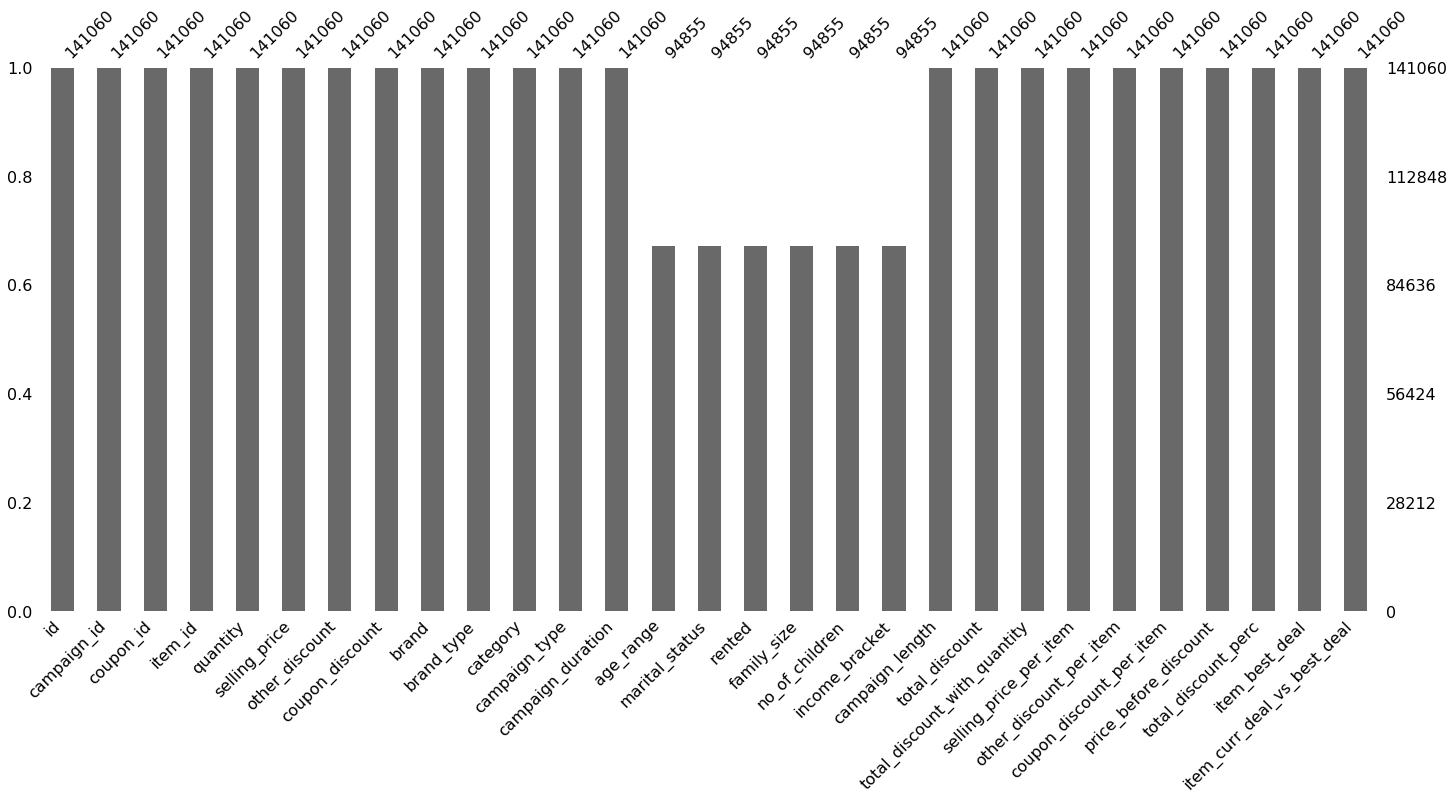

In [237]:
msn.bar(b)

In [238]:
b['campaign_length']=b['campaign_length'].abs()
b1['campaign_length']=b1['campaign_length'].abs()

In [239]:
b=pd.get_dummies(b,columns=['brand_type','category','campaign_type'])

In [240]:
b1=pd.get_dummies(b1,columns=['brand_type','category','campaign_type'])

In [241]:
#del b['no_of_children_new']

In [242]:
b.fillna(b.mean(),inplace=True)
b1.fillna(b1.mean(),inplace=True)

In [243]:
b.columns

Index(['id', 'campaign_id', 'coupon_id', 'item_id', 'quantity',
       'selling_price', 'other_discount', 'coupon_discount', 'brand',
       'campaign_duration', 'age_range', 'marital_status', 'rented',
       'family_size', 'no_of_children', 'income_bracket', 'campaign_length',
       'total_discount', 'total_discount_with_quantity',
       'selling_price_per_item', 'other_discount_per_item',
       'coupon_discount_per_item', 'price_before_discount',
       'total_discount_perc', 'item_best_deal', 'item_curr_deal_vs_best_deal',
       'brand_type_Established', 'brand_type_Local', 'category_Bakery',
       'category_Dairy, Juices & Snacks', 'category_Flowers & Plants',
       'category_Garden', 'category_Grocery', 'category_Meat',
       'category_Miscellaneous', 'category_Natural Products',
       'category_Packaged Meat', 'category_Pharmaceutical',
       'category_Prepared Food', 'category_Salads', 'category_Seafood',
       'category_Skin & Hair Care', 'category_Travel',
       'c

In [244]:
xtrain,xtest,ytrain,ytest=train_test_split(b,y)

In [245]:
xtrain.shape , xtest.shape

((105795, 46), (35265, 46))

In [246]:
xtr_id=xtrain['id']
del xtrain['id']


xtst_id=xtest['id']
del xtest['id']




In [247]:
test_id=b1['id']
del b1['id']


In [248]:
train_id=b['id']
del b['id']


In [249]:
del xtrain['campaign_id']
del xtrain['coupon_id']

del xtest['campaign_id']
del xtest['coupon_id']

del b['campaign_id']
del b['coupon_id']


del b1['campaign_id']
del b1['coupon_id']

In [250]:
xtrain.head()

,item_id,quantity,selling_price,other_discount,coupon_discount,brand,campaign_duration,age_range,marital_status,rented,...,category_Packaged Meat,category_Pharmaceutical,category_Prepared Food,category_Salads,category_Seafood,category_Skin & Hair Care,category_Travel,category_Vegetables (cut),campaign_type_0,campaign_type_1
11322,12801.0,2.0,27.07,0.00,0.0,1149.0,32,26.000000,1.000000,0.000000,...,0,1,0,0,0,0,0,0,0,1
114502,36578.0,1.0,21.37,-6.77,0.0,1337.0,48,36.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
17715,40862.0,1.0,70.88,0.00,0.0,602.0,48,39.902209,0.093469,0.055295,...,0,0,0,0,0,0,0,0,1,0
23511,5025.0,1.0,99.38,0.00,0.0,1337.0,47,26.000000,-1.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
53717,7540.0,1.0,14.96,0.00,0.0,1149.0,34,36.000000,1.000000,0.000000,...,0,1,0,0,0,0,0,0,0,1


In [252]:
xtrain.head()

,item_id,quantity,selling_price,other_discount,coupon_discount,brand,campaign_duration,age_range,marital_status,rented,...,category_Packaged Meat,category_Pharmaceutical,category_Prepared Food,category_Salads,category_Seafood,category_Skin & Hair Care,category_Travel,category_Vegetables (cut),campaign_type_0,campaign_type_1
11322,12801.0,2.0,27.07,0.00,0.0,1149.0,32,26.000000,1.000000,0.000000,...,0,1,0,0,0,0,0,0,0,1
114502,36578.0,1.0,21.37,-6.77,0.0,1337.0,48,36.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
17715,40862.0,1.0,70.88,0.00,0.0,602.0,48,39.902209,0.093469,0.055295,...,0,0,0,0,0,0,0,0,1,0
23511,5025.0,1.0,99.38,0.00,0.0,1337.0,47,26.000000,-1.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
53717,7540.0,1.0,14.96,0.00,0.0,1149.0,34,36.000000,1.000000,0.000000,...,0,1,0,0,0,0,0,0,0,1


In [253]:
#import category_encoders as ce
from sklearn.preprocessing import StandardScaler

In [259]:
clf=RandomForestClassifier()

In [260]:
clf.fit(xtrain,ytrain)

C:\Users\gurbaksh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [261]:
print(classification_report(ytest,clf.predict(xtest)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     30344
           1       0.89      0.74      0.81      4921

    accuracy                           0.95     35265
   macro avg       0.92      0.86      0.89     35265
weighted avg       0.95      0.95      0.95     35265



In [262]:
confusion_matrix(ytest,clf.predict(xtest))

array([[29895,   449],
       [ 1285,  3636]], dtype=int64)

In [263]:
test_pre=clf.predict(xtest)

In [264]:
roc_auc_score(ytest,clf.predict(xtest))

0.8620386090474689

In [265]:
len(xtst_id.unique())

7533

In [266]:
xtst_id.shape

(35265,)

In [267]:
test_pre

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# converting predictions into actual states

In [268]:
#null_id=tr[(tr.item_id.isnull())].id.unique()

df=pd.DataFrame()
df['id']=xtst_id
df['target']=test_pre
dff=df.groupby('id',as_index=False)['target'].agg(pd.Series.mean)
dff['actual']=train[train.id.isin(dff.id)].redemption_status.values


In [269]:
dff.head()

,id,target,actual
0,15,0.000000,0
1,22,0.000000,0
2,25,0.333333,0
3,29,0.000000,0
4,72,0.333333,1


In [270]:
def change(num):
    if  num<0.1:
        return 0
    else:
        return 1

family=dff.apply(lambda x: change(x['target']),axis=1)
dff['target']=family


In [271]:
confusion_matrix(dff['actual'].values,dff['target'].values)

array([[6718,  216],
       [  92,  507]], dtype=int64)

In [272]:
print(classification_report(dff['actual'].values,dff['target'].values))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6934
           1       0.70      0.85      0.77       599

    accuracy                           0.96      7533
   macro avg       0.84      0.91      0.87      7533
weighted avg       0.96      0.96      0.96      7533



In [273]:
roc_auc_score(dff['actual'].values,dff['target'].values)

0.9076299167972002

In [274]:
b.shape,xtest.shape

((141060, 43), (35265, 43))

In [275]:
xtrain.shape

(105795, 43)

In [91]:
a=xtrain.columns & b1.columns

In [276]:
#clf.fit(b[a],y)
test_pre=clf.predict(b1)

# Marking all transaction as No redemption where no item is present

In [94]:
null_id=ts[(ts.item_id.isnull())].id.unique()

df=pd.DataFrame()
df['id']=null_id
df['target']=0

In [95]:
len(null_id)+len(test_id.unique()),test.shape,len(test_pre)

(50226, (50226, 4), 124628)

In [96]:
dff=pd.DataFrame()
dff['id']=test_id
dff['target']=test_pre

In [97]:
dff=dff.groupby('id',as_index=False)['target'].agg(pd.Series.mean)


In [98]:
dff.head()

,id,target
0,3,0.133333
1,4,0.000000
2,12,0.000000
3,18,0.000000
4,47,0.000000


In [99]:
def change(num):
    if  num<0.1:
        return 0
    else:
        return 1

family=dff.apply(lambda x: change(x['target']),axis=1)
dff['target']=family


In [100]:
test.head()

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


In [101]:
a=pd.merge(test,dff,how='left',on='id')

In [102]:
a.target.fillna(0,inplace=True)

In [103]:
a.head()

,id,campaign_id,coupon_id,customer_id,target
0,3,22,869,967,1.0
1,4,20,389,1566,0.0
2,5,22,981,510,0.0
3,8,25,1069,361,0.0
4,10,17,498,811,0.0


In [104]:
a['redemption_status']=a['target'] 

In [105]:
a=a.sort_values(by='id')

In [106]:
a.describe()

,id,campaign_id,coupon_id,customer_id,target,redemption_status
count,50226.000000,50226.000000,50226.000000,50226.000000,50226.000000,50226.000000
mean,64220.021941,19.411659,589.657249,812.407140,0.007944,0.007944
std,37116.132742,2.382066,312.242707,456.725166,0.088776,0.088776
min,3.000000,16.000000,28.000000,1.000000,0.000000,0.000000
25%,31964.500000,18.000000,266.000000,432.000000,0.000000,0.000000
50%,64279.500000,18.000000,592.000000,826.000000,0.000000,0.000000
75%,96235.000000,21.000000,864.000000,1209.000000,0.000000,0.000000
max,128594.000000,25.000000,1116.000000,1582.000000,1.000000,1.000000


In [107]:
a[['id','redemption_status']].to_csv('sub_rf11.csv',index=False)